In [86]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [238]:
def sample(d):
    return torch.concat((torch.rand(d), torch.ones(1)))

class Classifier():
    def __init__(self, m, d, fn=None):
        self.m = m
        self.d = d
        self.fn = fn
        self.data = set([])
    
    def classify(self, x): # n x m
        if self.fn is None:
            raise NotImplementedError
        return self.fn(x)
    
    def retrain(self, rewarder, data=None):
        raise NotImplementedError

class Rewarder():
    def __init__(self, classifier, loss_fn):
        self.classifier = classifier
        self.loss_fn = loss_fn
    
    def __call__(self, data, y_hats):
        y_trues = self.classifier.classify(data).detach()
#         print(y_hats.shape, y_trues.shape)
        return self.loss_fn(y_hats, y_trues)
        
class LinClf(Classifier):
    def __init__(self, m, d, phi=None):
        super().__init__(m, d)
        self.phi = torch.rand((m, d + 1)) if phi is None else phi
    
    def classify(self, x):
        vals = self.phi @ x.T # m x n
        max_classes = torch.argmax(vals, dim=0)
        return nn.functional.one_hot(max_classes, num_classes=self.m).T
    
    def retrain(self, rewarder, data=None, lmbda=0.0, alpha=0.0):
        data = self.data if data is None else data
        n = data.shape[0]
        y_hats = self.classify(data)
        rewards = rewarder(data, y_hats)
        
        action_indexes = {}
        for a in range(self.m):
            action_indexes[a] = []
        for t in range(n):
            a = torch.argmax(y_hats[t]).item()
            action_indexes[a].append(t)
        phi = torch.zeros((self.d + 1, self.m))
        for a in range(self.m):
            ii = action_indexes[a]
            dataset_a = data[ii]
            rewards_a = rewards[ii]
            xtx = dataset_a.T @ dataset_a + lmbda * torch.eye(self.d + 1)
            xtr = dataset_a.T @ rewards_a
#             if len(xtr.shape) == 1:
#                 xtr = xtr.unsqueeze(1)
#             print(xtx.shape, xtr.shape, dataset_a.T.shape, rewards_a.shape)
#             print(torch.linalg.pinv(xtx))
#             print(torch.linalg.pinv(xtx) @ xtr)
#             print(phi, phi[:,a])
            phi[:,a] = torch.linalg.pinv(xtx) @ xtr
            phi[:,a] += alpha * np.sqrt(np.log(n+1) / (len(ii)+1)) # UCB exploration term
        self.phi = phi.T # want m x d output
        
class SoftLinClf(LinClf):
    def __init__(self, m, d, temp, phi=None):
        super().__init__(m, d, phi)
        self.sm = nn.Softmax(dim=0)
        self.temp = temp
    
    def classify(self, x):
        return self.sm(self.phi @ x.T / self.temp).T


In [239]:
torch.argmax(torch.tensor([[0.3, 0.7], [0.6, 0.3]]), dim=0)
# torch.argmax(torch.tensor([0.3, 0.7]), dim=0)
nn.functional.one_hot(torch.argmax(torch.tensor([0.3, 0.7]), dim=0), num_classes=2)

tensor([0, 1])

In [240]:
m, d = 2, 2
num_clfs = 2
n = 10_000
temperature = 0.02

In [260]:
def quadr_fn_maker(x_cutoff=0.5, y_cutoff=0.5, x_gt=True, y_gt=True):
    def comp(x_pt):
        v0 = x_pt[0] > x_cutoff if x_gt else x_pt[0] <= x_cutoff
        v1 = x_pt[1] > y_cutoff if y_gt else x_pt[1] <= y_cutoff
        return v0 and v1
    def quadr(x):
        if len(x.shape) == 1:
            x = torch.stack([x])
        return torch.tensor([float(comp(datapoint)) for datapoint in x], dtype=torch.long)
    return quadr

true_clf = Classifier(m=m, d=d, fn=quadr_fn_maker(x_cutoff=0.4, y_cutoff=0.4, x_gt=True, y_gt=True))
rewarder = Rewarder(classifier=true_clf, loss_fn=nn.CrossEntropyLoss(reduction='none'))
classifiers = [SoftLinClf(m=m, d=d, temp=temperature) for _ in range(num_clfs)]
dataset = [sample(d) for _ in range(n)]

In [261]:
# classifiers[1].phi = torch.tensor([[0.0137, 0.9187, 0.3450], [0.5888, 0.1009, 0.4220]])
classifiers[1].phi = -torch.tensor([[1., 0., 0.], [0., 1., 0.]])
classifiers[0].phi = torch.tensor([[-1, 1, 1], [1, 1, 0.]])

C:\Users\Alex\AppData\Local\Temp\ipykernel_31532\3015715433.py:9: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor([float(comp(datapoint)) for datapoint in x], dtype=torch.long)


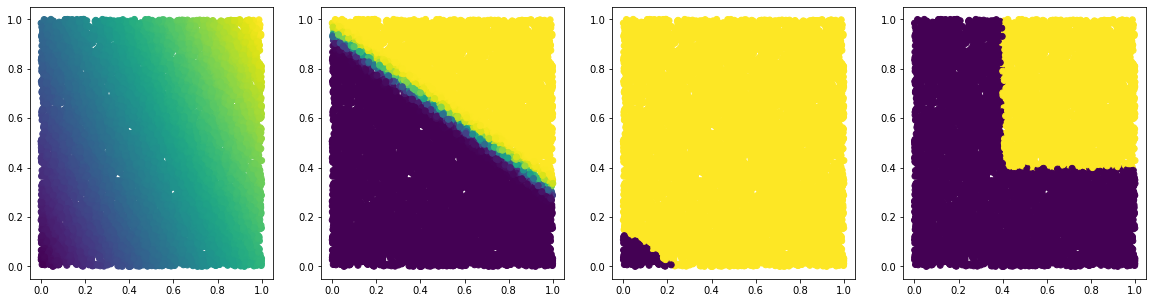

In [276]:
chosen_clfs = []
clf_datasets = [[] for _ in range(num_clfs)]
for x in dataset:
    classifications = [c.classify(x)[0] for c in classifiers]
    c = np.argmax(classifications)
    chosen_clfs.append(c)
    clf_datasets[c].append(x)

td = torch.stack(dataset)
fig, ax = plt.subplots(1, num_clfs + 2, figsize=((num_clfs + 2) * 5, 5))
for i in range(num_clfs):
    ax[i].scatter(td[:,0], td[:,1], c=classifiers[i].classify(td)[:,0].numpy().tolist())
ax[-2].scatter(td[:,0], td[:,1], c=chosen_clfs)
ax[-1].scatter(td[:,0], td[:,1], c=true_clf.classify(td)[:].numpy().tolist())

In [277]:
for i in range(num_clfs):
    if len(clf_datasets[i]) == 0:
        continue
    classifiers[i].retrain(rewarder=rewarder, data=torch.stack(clf_datasets[i]))

C:\Users\Alex\AppData\Local\Temp\ipykernel_31532\3015715433.py:9: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor([float(comp(datapoint)) for datapoint in x], dtype=torch.long)
